<a href="https://colab.research.google.com/github/amitkag85/AILearning/blob/master/9__Fine_Tuning_Transformer_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Language Models

Most models are called pre-trained (that is what the "P" in "GPT" stands for). This means that they are trained on general purpose data, typically from a large number of diverse sources and domains, rather than on anything for a specific task. These pre-trained models learn a lot about how the data works (for language models specifically, they learn things like grammar, the structure of documents, etc.). It turns out that with a large enough model, trained on enough data, even this pre-training can result in a very powerful model (such as GPT-3 and its successors), which can be coerced into performing many tasks just by prompting them appropriately.

However, for smaller models, or to have more control over larger ones, you often need to train on data that closely matched your desired task. This is called **fine tuning**. The idea is that you can nudge the model closer to the task you are interested in by showing it more examples of what you want it to be better at.

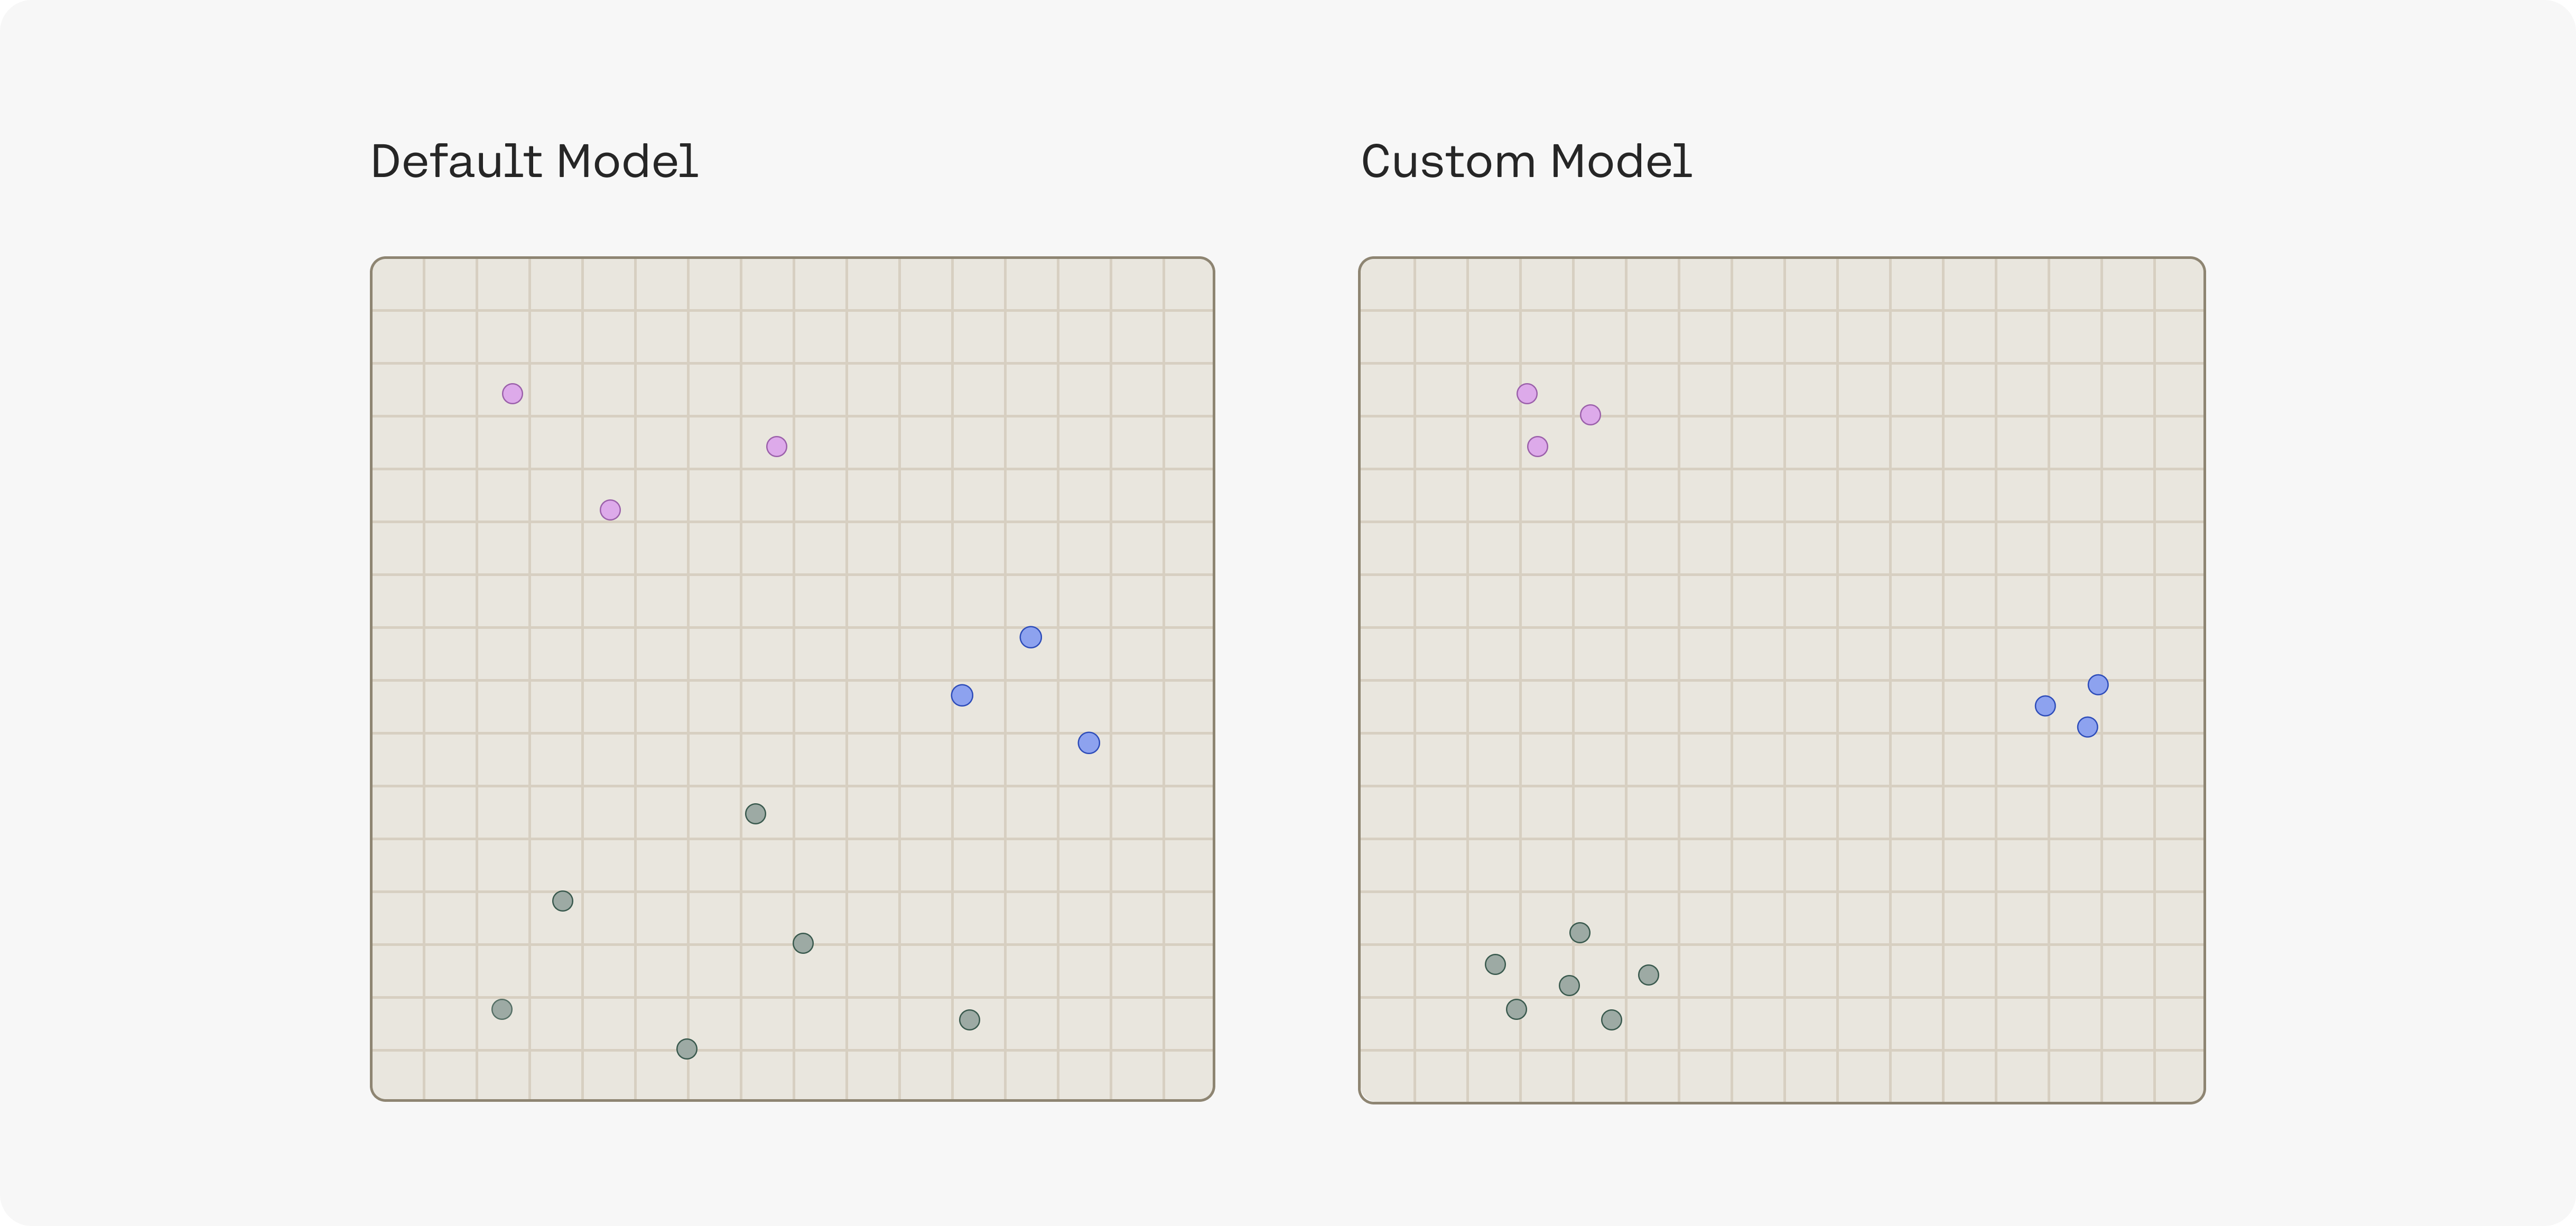

(image credit Cohere AI)

Fine tuning takes significantly less data than training a model from scratch. The reason you generally do not train models purely on task-specific data is that:

* you generally do not have enough examples
* the task-specific data may not contain enough information for the model to learn more general concepts

# Closed-source Models

Most of the currently best performing models available are closed source. This means that you do not have direct access to the model (the code, trained weights, or both). Interactions are typically done via an API. This means that you do not need to deal with all the complexity of deploying and maintaining the model yourself, at the expense of having only limited access to its functionality.

Another consideration is that with closed models, you do not have any guarantees as to what the company will do with any data you send to them. Some use cases involve sensitive information, and not everyone is comfortable with the thought that the API provided _could_ use it for training future iterations of their models.

## OpenAI

Via their [API](https://platform.openai.com/docs/api-reference/fine-tunes), OpenAI allows you to create fine tuned versions of some of their models. This basically consists of you supplying custom data, they handle the training and provide you with the resulting model. Do note that OpenAI recently announced would be removing a number of GPT-3 based models, including any fine tuned versions customers have made:

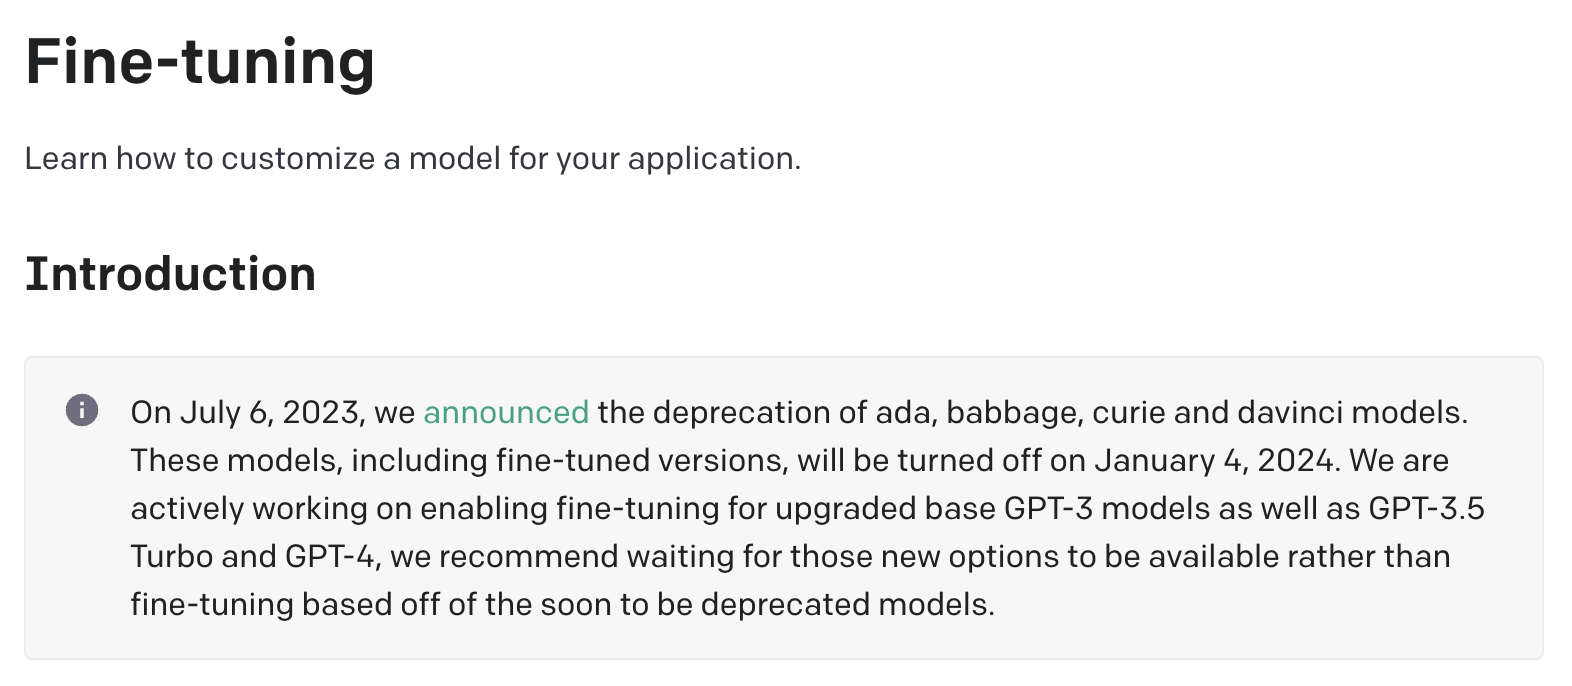

Because of this, I would caution against relying on OpenAI fine tunes. Any money that you spent on themm will be list, and any functionality you built that relies on them will stop working.

## Cohear

Another player in the language model space is [Cohere AI](https://cohere.com/). Their models seem to be somewhat on par with OpenAI, although you really need to play with them to get a feel for how they behave.

They also provide the ability to [train custom models](https://docs.cohere.com/docs/training-custom-models) [API documentation](https://docs.cohere.com/reference/finetune). Although Cohere has not yet announced any similar deprecation like OpenAI, it is possible that they may do so at some point as well.


# Open-source Models

Open source models mean that the code and usually trained weights are available for direct use. This means that you can have total control over the model and fine tuning process, at the expense of needing to handle everything yourself.

Currently there are many open source models, but none of them are at the same level as GPT-4. Additionally, many of the better/larger open source models have a non-commercial licence (such as [Llama](https://ai.meta.com/blog/large-language-model-llama-meta-ai/)), so you need to make sure a model allows your particular use case. However, since LLM research and development progresses so rapidly, it is likely that there will be a good open alternative to closed models that also allows commercial use in the not too distant future.

UPDATE: as of 7/19/2023, Meta released Llama-v2, which is not only a much better model, but also allows for commercial use:

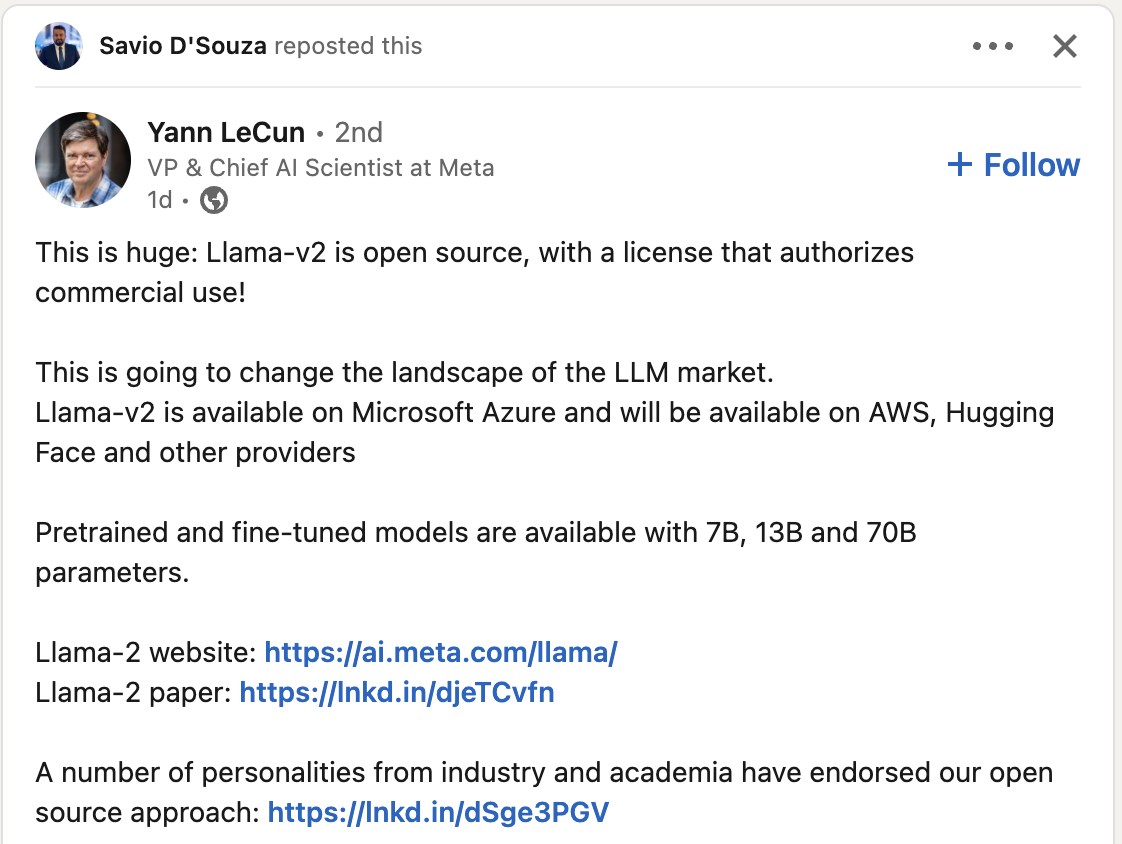

Llama-2 website: https://ai.meta.com/llama/

Llama-2 paper: https://lnkd.in/djeTCvfn

## Huggingface

Below we will be using Huggingface and an adapted version of a notebook they provide for [fine tuning a language model](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/language_modeling.ipynb).

In [ ]:
!pip install accelerate -U
!pip install transformers[torch] datasets

## Training data for Wikitext

For this example, we will be using the [Wikitext dataset](https://huggingface.co/datasets/wikitext). The `load_dataset` function will download the dataset for us.

In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

## Loading Your Own Data

Since you likely want to fine tune on your own custom data, [here](https://huggingface.co/docs/datasets/loading#csv) is the documentation about `load_dataset`. The below example uses the `"text"` argument, which is actually documented [here](https://huggingface.co/docs/datasets/nlp_load) instead for some reason. The text files are sampled by newline by default, but you can adjust that with various arguments.

To use your own data, make sure it is somewhere in your google drive, uncomment the following line, and change the filenames.

In [ ]:
# datasets = load_dataset("text", data_files={"train": path_to_train.txt, "validation": path_to_validation.txt}

Now we can look at a training example:

In [ ]:
datasets["train"][10]

In [ ]:
len(datasets["train"])

This is just a helper function for quickly getting a sense of what a sample of examples look like:

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

# The Model

Since we are fine tuning, we start with a pre-trained model checkpoint. In this case, we will use [DistilGPT2](https://huggingface.co/distilgpt2). Since we will be referencing the model name multiple times, we'll assign it to a variable.

In [ ]:
model_checkpoint = "distilgpt2"

As with all models that use text, we need to load the appropriate tokenizer that the corresponding model was trained with.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

This is a helper function that will allow us to more easily tokenize a given example. It is also important because we will be using `map` to apply that function to every example in the dataset.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

In [ ]:
tokenized_datasets["train"][1]

This next section is about making sure that all examples we send to the model are the same length. This is important during training as it allows us to batch multiple examples together, which speeds up training and helps the model to generalize better.

In [ ]:
# block_size = tokenizer.model_max_length
block_size = 128

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Here is an example of converting the tokenized data back into strings.

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

Now we load the model itself from the checkpoint.

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

## Training

Huggingface offers a convenient [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class which handles most of the training process for us.

In [ ]:
from transformers import Trainer, TrainingArguments

We set the arguments for the trainer here. The first argument is the path where the checkpoints will be saved while training. A checkpoint is a copy of the model after some number of example, which is helpful in case:

* training stops for some reason and you need to restart from where you left off
* if you had bad luck and your loss started getting worse, you can try again from a checkpoint before the issue happened

In [ ]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"/content/drive/MyDrive/Colab Notebooks/{model_name}-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,  # setting this to false because we are not logging into hub
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

Actually run training. Note that this will take a while. Make sure you set your runtime to use a GPU.

In [ ]:
trainer.train()

Here we can get a measure of how well the model is performing. We will use [perplexity](https://en.wikipedia.org/wiki/Perplexity) as the metric based on the loss on the evaluation data.

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Now we can save our model. Change the name and path to anything you like.

In [ ]:
trainer.save_model("my_cool_model")

In the `Files` tab on the left side, you should see this:

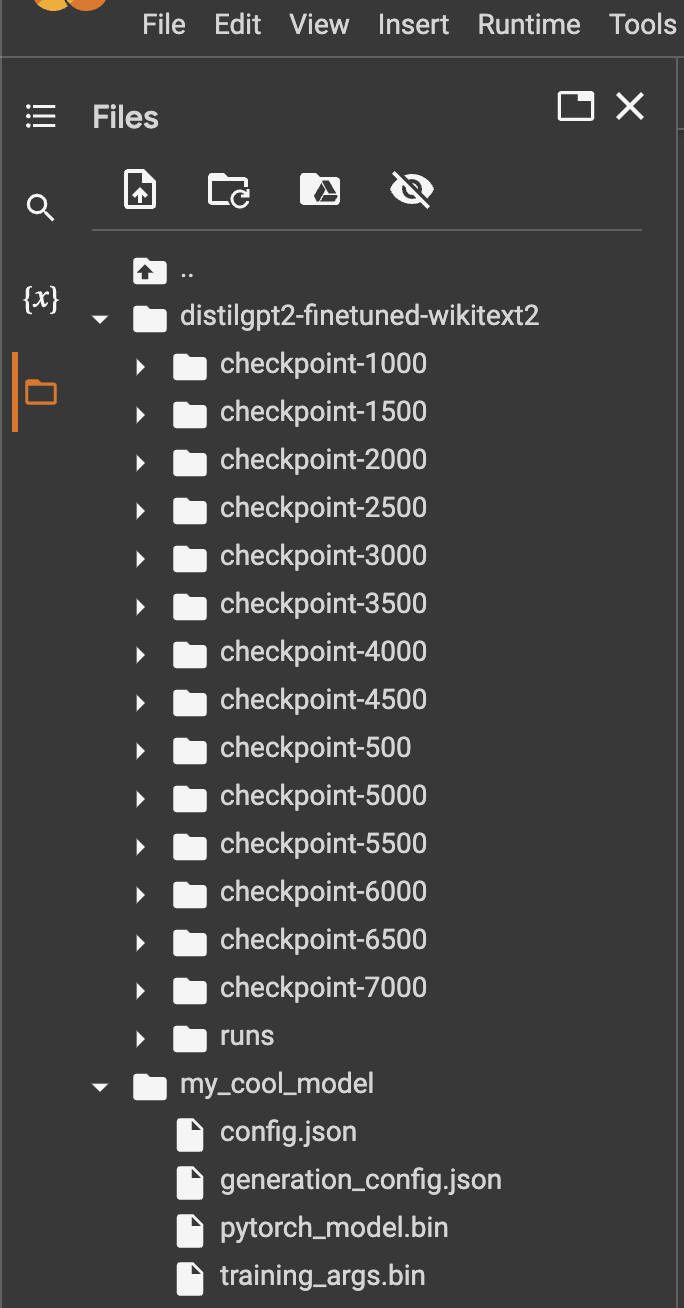

Now you can load your model again by passing the path to the folder we just saved:

In [ ]:
model = AutoModelForCausalLM.from_pretrained("./my_cool_model/")
print(model.eval())

# Considerations

If you are saving the model like this, you should make sure to either download the folder, or put it in your google drive (click `Files` on the left, click `Mount Drive`, and pick a location within that). Otherwise your saved model and all checkpoints will be lost once the runtime is disconnected.

You can choose any causal language model as the base to fine tune, provided that you have enough resources to train it. GPT-2 is old and small by today's standards. If you wanted to use a newer/larger base model, such as StableLM, you would need to make sure that the machine you are fine tuning it on can support it.

# When to use a Language Model

Since the release of ChatGPT, language models have been all the rage. It is important to remember that a) they are nothing new (although the quality and usefullness has certainly improved), and b) they are not the only tool available for solving NLP tasks.

## Language Model Tasks

Language models, large or otherwise, are trained to predict the next "thing" in a sequence. Typically the "thing" is a token, which can be a character, word, or part of a word, depending on how the chosen tokenizer works. Given an input sequence, the model outputs the probability distribution of next tokens. From that probability distribution, the next token is sampled somehow (typically with a weighted random choice). The chosen token is then appended to the original input and the new sequence is fed back into the model again. This is caulled [autoregression](https://en.wikipedia.org/wiki/Autoregressive_model).

The important point to note is that a language model can only **continue the sequence**. They give you more of what you present to them based on repeated probabilistic choices.

General purpose language models, including what we fine tuned above, are **not** chatbots. They can however be convinced to be with additional fine tuning. What turns something like GPT-3 into ChatGPT is called [reinforcement learning with human feedback](https://huggingface.co/blog/rlhf) (RLHF). Or at least that is the part of the picture that gets the most hype. You can achieve most of what is needed through standard fine tuning without using RLHF at all.

[Here](https://www.youtube.com/watch?v=bZQun8Y4L2A) is a video of Andrej Karpathy recently discussing the current state of language models.

## Classification

Things like classification (e.g. sentiment analysis) are not specifically language modeling tasks. For that, we typically use [masked language models](https://huggingface.co/docs/transformers/main/tasks/masked_language_modeling) such as BERT. These are similar in structure to language models, except that they are typically used to gather information into a single `CLS` token that can be used for classification.

It is _possible_ to use a language model for classification, but it may not always be the best option. In order to do so, you need to format your training data to have:

* the input you are trying to classify
* some identifier that informs the model that it will need to output a classification (e.g. `"sentiment => "`)
* followed by the text you want to classify the example as

It is worth noting that large language models can often do this task via zero/few-shot learning:

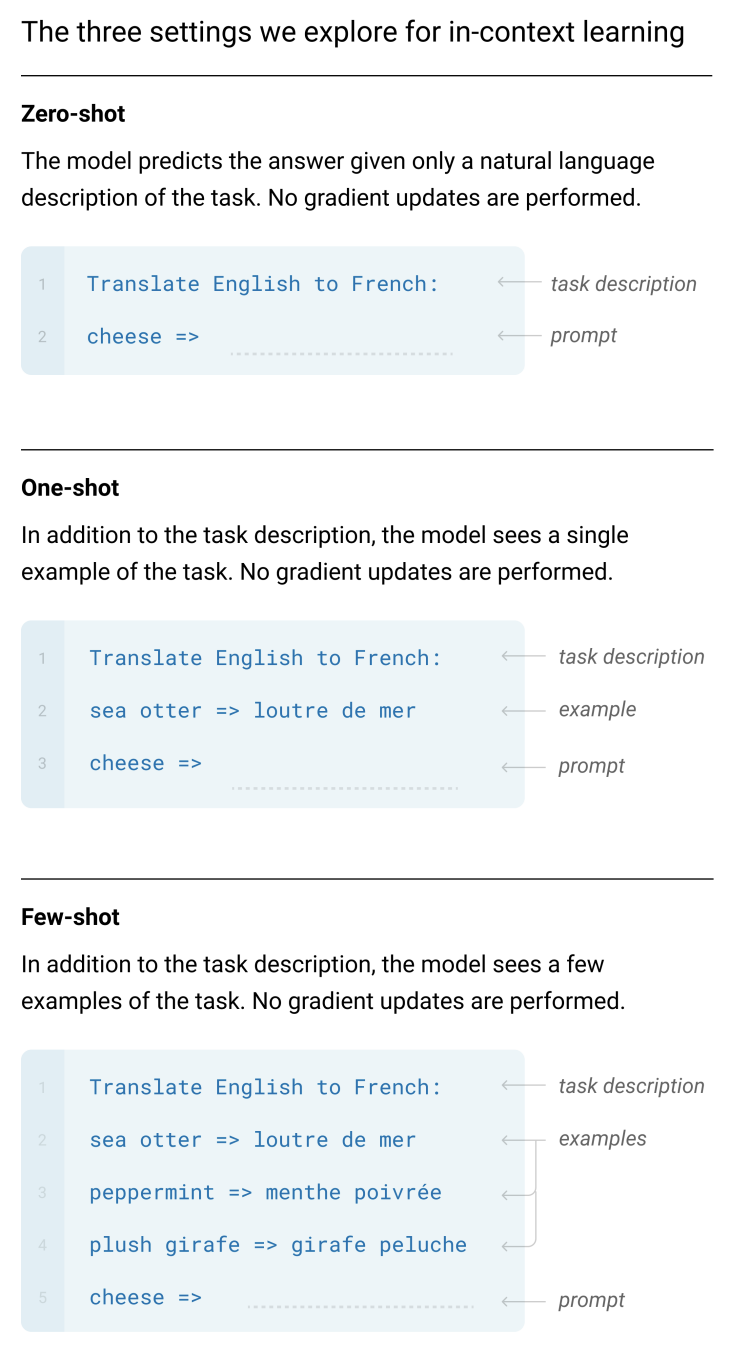

While it does work to have language models function as classifiers, whether after being fine tuned or via in-context learning, there are a few things to keep in mind:

* In order to use the classification in a system, you will need to parse the output from the model somehow. This can be difficult sometimes either due to there being multiple occurances of what you are looking for, the model refusing to produce output in the format you are expecting, etc.
* It takes multiple forward passes of the model to finish the text completion in order for you to receive the desired output. With a classification model, there would be only one forward pass. It is important to remember that running models costs money, whether you are paying for an API or your own infrastructure.
* Language models are capable of giving open ended responses. This could be an advantage if your problem requires that, but can be an issue otherwise. The model could hallucinate entirely new classes, rather than simply outputting an incorrect choice.

The choice of whether to use a language model for classification comes down to cost and ease of use. It could be that your system is so well suited to use a language model that adding a new model to the ecosystem may not make sense. On the other hand, the added effort could pay off in reduced development time for engineering around issues with parsing output, or could be less expensive. These are all factors to consider when choosing to use a language model or not.